In [368]:
#import & load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil import parser

%pylab inline
pylab.rcParams['figure.figsize'] = (16, 9)

df_apps = pd.read_csv('googleplaystore_origin.csv')
df_apps.head()

Populating the interactive namespace from numpy and matplotlib


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [369]:
for col in df_apps.columns:
    print(col, type(df_apps[col][1]))

App <class 'str'>
Category <class 'str'>
Rating <class 'numpy.float64'>
Reviews <class 'str'>
Size <class 'str'>
Installs <class 'str'>
Type <class 'str'>
Price <class 'str'>
Content Rating <class 'str'>
Genres <class 'str'>
Last Updated <class 'str'>
Current Ver <class 'str'>
Android Ver <class 'str'>


In [370]:
#row 10472 doesn't have value for category; its following values are shifted
#shift the row to make it right
df_apps.iloc[10472] = df_apps.iloc[10472].shift(1)
df_apps.loc[10472, 'App'] = df_apps.loc[10472, 'Category']
df_apps.loc[10472, 'Category'] = ''

In [371]:
#data type transformations
def to_int(x):
    if ''.join(str(x).split('.')).isdigit():
        return int(x)
    else:
        print('not digit',x)
        
def size_to_float(x):
    if len(str(x))>0:
        out = 0.0
        if x[-1] in ['M','m']:
            out = float(''.join(x[:-1].split('.'))) * 1000
        elif x[-1] in ['K','k']:
            out = float(''.join(x[:-1].split('.')))
        else:
            out = -1
        return out
    else:
        return 0
    
def install_to_int(x):
    if x[-1] == '+':
        return int(''.join(x[:-1].split(',')))
    else:
        return 0
    
def price_to_float(x):
    if x[0] == '$':
        return float(''.join(x[1:].split('.')))
    else:
        return 0.0
    
def str_to_date(x):
    try:
        dt = parser.parse(x)
        return dt
    except:
        print('problem date:', x)
    
df_apps.Reviews = df_apps.Reviews.apply(to_int)
df_apps.Size = df_apps.Size.apply(size_to_float)

#keeping original Installs column
df_apps['installs_int'] = df_apps.Installs.apply(install_to_int)
df_apps.Price = df_apps.Price.apply(price_to_float)
df_apps['Last Updated'] = df_apps['Last Updated'].apply(str_to_date)

In [372]:
#encode Category only
#not encoding type, since price will be 0 if type is free
#not using Genre for now
#compare different methods of encoding, do it later

df_apps.Category.unique()

array(['ART_AND_DESIGN', 'AUTO_AND_VEHICLES', 'BEAUTY',
       'BOOKS_AND_REFERENCE', 'BUSINESS', 'COMICS', 'COMMUNICATION',
       'DATING', 'EDUCATION', 'ENTERTAINMENT', 'EVENTS', 'FINANCE',
       'FOOD_AND_DRINK', 'HEALTH_AND_FITNESS', 'HOUSE_AND_HOME',
       'LIBRARIES_AND_DEMO', 'LIFESTYLE', 'GAME', 'FAMILY', 'MEDICAL',
       'SOCIAL', 'SHOPPING', 'PHOTOGRAPHY', 'SPORTS', 'TRAVEL_AND_LOCAL',
       'TOOLS', 'PERSONALIZATION', 'PRODUCTIVITY', 'PARENTING', 'WEATHER',
       'VIDEO_PLAYERS', 'NEWS_AND_MAGAZINES', 'MAPS_AND_NAVIGATION', ''], dtype=object)

In [373]:
#what's up with the repititions?
#it appears that data on the same app might have been collected mulitple times
#only keep the record with the largest number of reviews

print(len(df_apps), len(df_apps.App.unique()))
duplications = df_apps.App.value_counts()[df_apps.App.value_counts() > 1]


for app in duplications.keys():
    appearances = df_apps[df_apps.App == app]
    drop_i = appearances.sort_values('Reviews', ascending=False).index[1:]
    df_apps.drop(drop_i, inplace=True)
    
print(len(df_apps), len(df_apps.App.unique()))

10841 9660
9660 9660


In [375]:
#excluding apps with less than 5000 installs
drop_i = df_apps[df_apps.installs_int < 5000].index
df_apps.drop(drop_i, inplace=True)
len(df_apps)

6982

In [376]:
#construct extra columns

#reviews per install
df_apps['reviews_per_install'] = df_apps.Reviews/df_apps.installs_int

#days from last update to 20180831
end_date = datetime.datetime(2018,8,31,0,0,0)
def get_delta(x):
    d = end_date - x
    return d.days
df_apps['updated_delta'] = df_apps['Last Updated'].apply(get_delta)

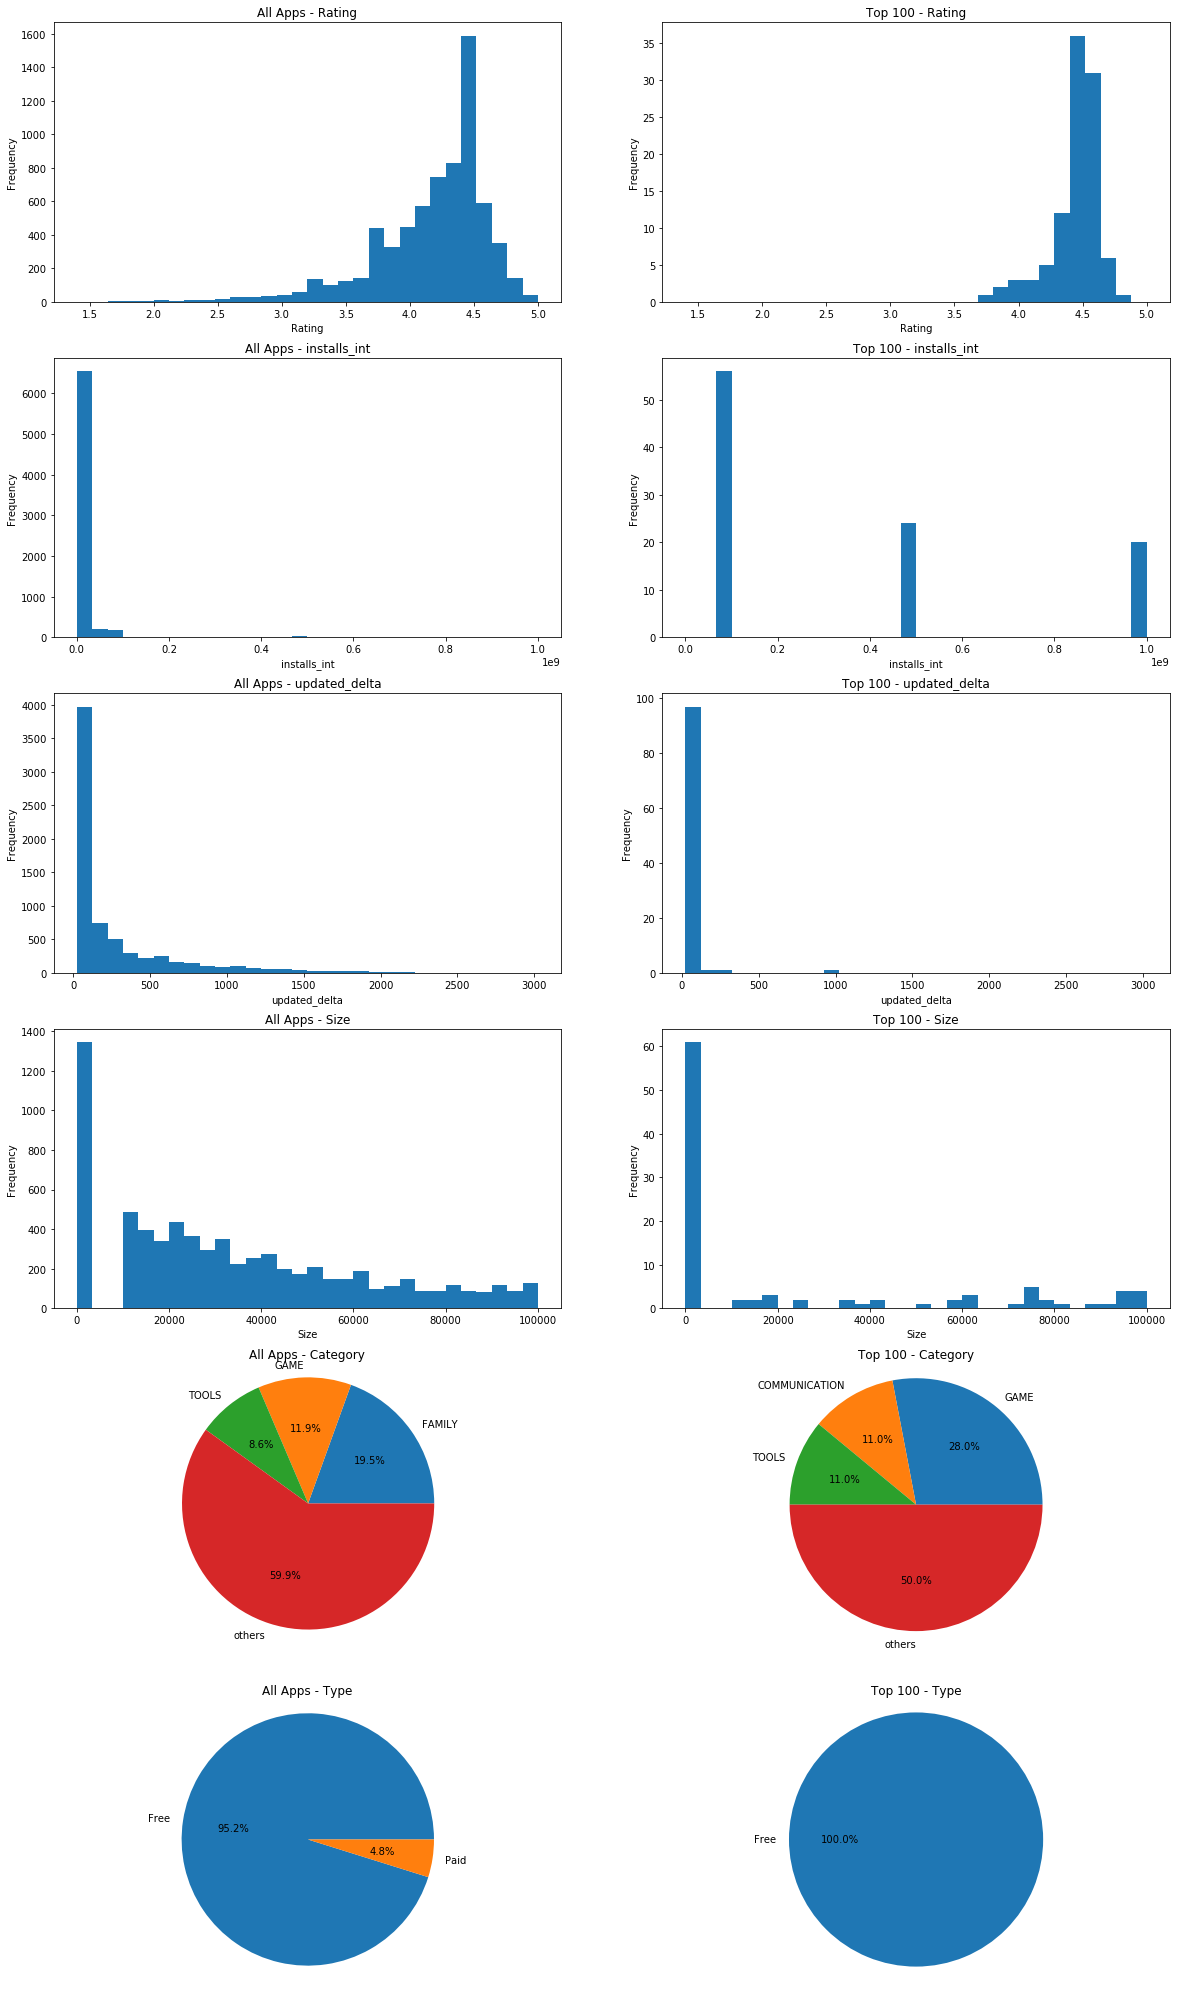

In [484]:
#comparisons of top100 and all
pylab.rcParams['figure.figsize'] = (20, 36)

#picking out the best apps
df_apps['rating_installs'] = df_apps.Rating * df_apps.installs_int
top_100 = df_apps.sort_values('rating_installs', ascending=False)[:100]

def comp_hist(col, ax):
    ax[0].hist(df_apps[col], bins=30, range=(df_apps[col].min(), df_apps[col].max()))
    ax[0].set_title(col)
    ax[0].set_title('All Apps - {}'.format(col))
    ax[0].set_xlabel(col)
    ax[0].set_ylabel('Frequency')
    
    ax[1].hist(top_100[col], bins=30, range=(df_apps[col].min(), df_apps[col].max()))
    ax[1].set_title(col)
    ax[1].set_title('Top 100 - {}'.format(col))
    ax[1].set_xlabel(col)
    ax[1].set_ylabel('Frequency')
    
    
def get_cate_counts(d, col):
    thres = 4
    cate_counts = d[col].value_counts()
    if len(cate_counts) > thres:
        tops = cate_counts[:thres-1]
        tops['others'] = cate_counts[thres-1:].sum() 
        cate_counts = tops
        
    return cate_counts
    
def comp_pie(col, ax):
    cate_all = get_cate_counts(df_apps, col)
    cate_top100 = get_cate_counts(top_100, col)
    
    ax[0].pie(cate_all, labels=cate_all.keys(), autopct='%1.1f%%')
    ax[0].axis('equal')
    ax[0].set_title('All Apps - {}'.format(col))
    ax[1].pie(cate_top100, labels=cate_top100.keys(), autopct='%1.1f%%')
    ax[1].axis('equal')
    ax[1].set_title('Top 100 - {}'.format(col))
    
#comp_hist('Rating')
#comp_pie('Type')

#do comparisons
list_col_hist = [
    'Rating',
    'installs_int',
    'updated_delta',
    'Size'
]

fig = plt.figure(figsize=(16,20))
f, axarr = plt.subplots(6,2)

comp_hist('Rating', axarr[0])
comp_hist('installs_int', axarr[1])
comp_hist('updated_delta', axarr[2])
comp_hist('Size', axarr[3])
comp_pie('Category', axarr[4])
comp_pie('Type', axarr[5])
    
plt.show()
    

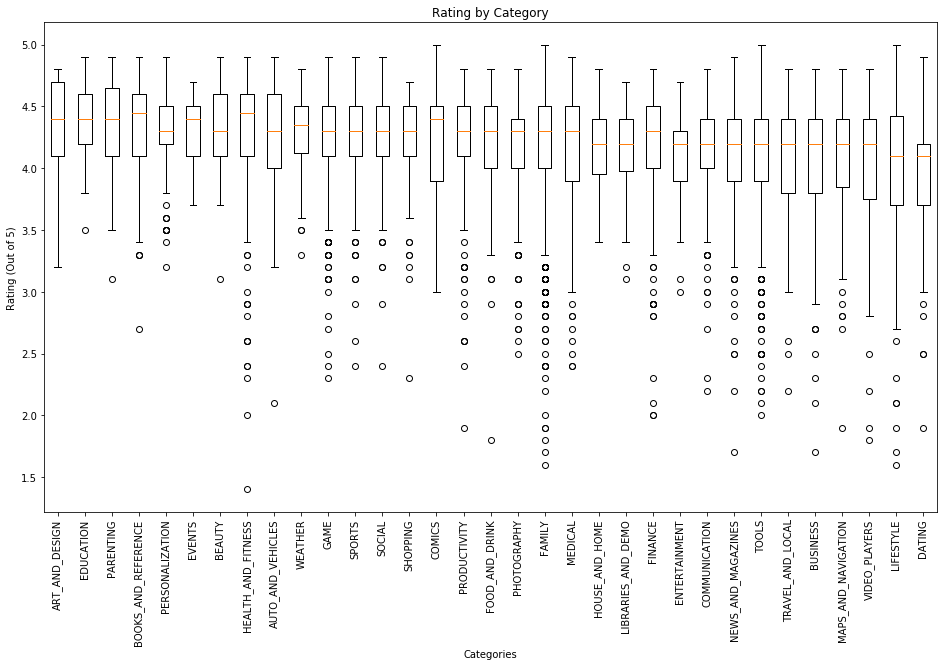

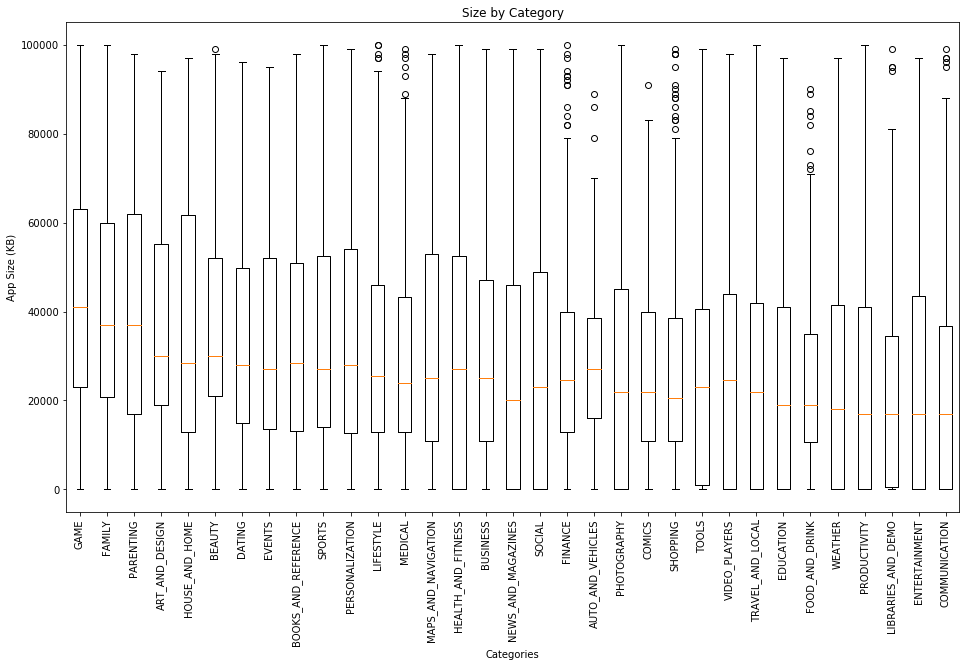

In [471]:
#compare installs & ratings by categories

def get_box_val(d, cate_val, agg_val):
    sep = d[d[group_col] == cate_val][agg_val]
    copy_ = sep.dropna()
    tmp_l = []
    for item in copy_:
        tmp_l.append(item)
    copy_ = pd.Series(np.array(tmp_l))
    return copy_

def sbs_box(d, group_col, val_col, y_label):
    #mean_rating_by_cate = d.groupby(group_col).Rating.sum() / d.groupby(group_col).Rating.count()

    #extract data to plot each boxplot
    box_data_arr = []
    for cate in categories:
        box_data_arr.append(get_box_val(d, cate, val_col))
        
    #sort data by mean of each boxplot
    sort_by_val = pd.DataFrame({
            'cate_':categories,
            'box_data':box_data_arr
        })
    
    sort_by_val['box_mean'] = sort_by_val['box_data'].apply(lambda x: x.sum()/len(x))
    sort_by_val.sort_values('box_mean', ascending=False, inplace=True)
    
    pylab.rcParams['figure.figsize'] = (16, 9)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    f = ax.boxplot(sort_by_val['box_data'])
    ax.set_xticks(range(1,len(sort_by_val)+1))
    ax.set_xticklabels(sort_by_val['cate_'], rotation=90)
    ax.set_title('{} by {}'.format(val_col, group_col))
    ax.set_xlabel('Categories')
    ax.set_ylabel(y_label)
    plt.show()
    
#compare rating & size distributions by category
categories = df_apps.Category.value_counts().keys()
sbs_box(df_apps, 'Category', 'Rating', 'Rating (Out of 5)')
sbs_box(df_apps, 'Category', 'Size', 'App Size (KB)')


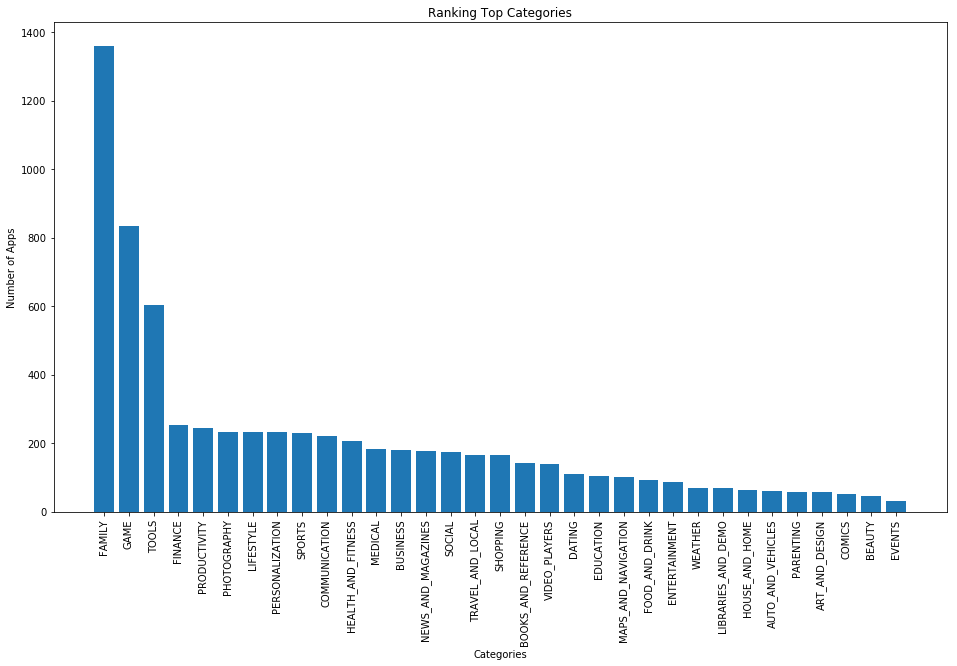

In [435]:
#rank number of apps by categories
app_counts = df_apps.Category.value_counts()

fig = plt.figure()
ax = fig.add_subplot(111)

xs = list(range(len(app_counts)))
ax.bar(xs, app_counts)
ax.set_xticks(xs)
ax.set_xticklabels(app_counts.keys(), rotation=90)
ax.set_title('Ranking Top Categories')
ax.set_xlabel('Categories')
ax.set_ylabel('Number of Apps')


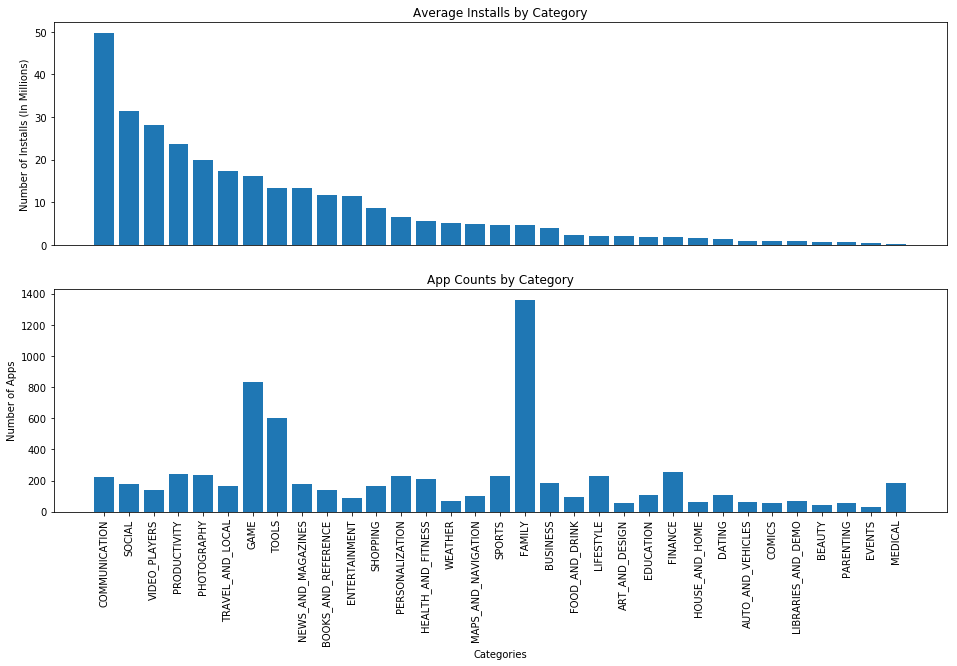

In [436]:
#rank average insatlls

categories = df_apps.Category.value_counts().keys()
pylab.rcParams['figure.figsize'] = (16, 9)
plt.figure()

means = []
for cate in categories:
    group_ = df_apps[df_apps.Category == cate]['installs_int']
    means.append(group_.mean())
    
sort_by_mean = pd.DataFrame({
        'cate_':categories,
        'means_':means
    })

sort_by_mean['means_'] = sort_by_mean.means_.apply(lambda x: x/1000000)

#adding a subplot of counts of apps by category
app_counts = df_apps.Category.value_counts()
app_counts_lookup = {}
for key, val in app_counts.iteritems():
    app_counts_lookup[key] = val    
sort_by_mean['app_count'] = sort_by_mean.cate_.apply(lambda x: app_counts_lookup[x])

sort_by_mean.sort_values('means_', ascending=False, inplace=True)

fig = plt.figure()

ax1 = fig.add_subplot(211)
xs = list(range(len(sort_by_mean)))
ax1.bar(xs, height=sort_by_mean.means_)
ax1.axes.get_xaxis().set_visible(False)
ax1.set_title('Average Installs by Category')
ax1.set_ylabel('Number of Installs (In Millions)')

ax2 = fig.add_subplot(212)
ax2.bar(xs, height=sort_by_mean.app_count)
ax2.set_xticks(xs)
ax2.set_xticklabels(sort_by_mean.cate_, rotation=90)
ax2.set_title('App Counts by Category')
ax2.set_xlabel('Categories')
ax2.set_ylabel('Number of Apps')

plt.show()

In [382]:
#top apps in categories

def plot_tops(row_in_group, ax):
    xs = list(range(len(row_in_group)))
    ax.bar(xs, row_in_group['Rating'])
    ax.set_xticks(xs)
    ax.set_xticklabels(row_in_group['App'], fontsize=20)
    ax.set_ylim(ymin=4.5)

pylab.rcParams['figure.figsize'] = (32, 100)
categories = df_apps.Category.value_counts().keys()
col_num = 2
#n = len(categories)//col_num
n=6
#f, axarr = plt.subplots(n, col_num)

k = 0
for i_col in range(col_num):
    for i_row in range(n):
    
        rows_in_group = df_apps[df_apps['Category'] == cate]
        rows_in_group = rows_in_group.sort_values(by='installs_int', ascending=False)[['App','Rating']][:3]

        cate = categories[k]
        #ax = axarr[i_row][i_col]
        #plot_tops(rows_in_group, ax)
        print(cate, '\n', rows_in_group, '\n')
        
        k+=1
    
#plt.show()


FAMILY 
                                                   App Rating
1005                       Ticketmaster Event Tickets      4
1008   StubHub - Tickets to Sports, Concerts & Events      4
1020  Gametime - Tickets to Sports, Concerts, Theater    4.5 

GAME 
                       App Rating
5856    Google Play Games    4.3
6849  Bubble Witch 2 Saga    4.3
2206               ROBLOX    4.5 

TOOLS 
                  App Rating
1872  Subway Surfers    4.5
1908  My Talking Tom    4.5
1920    Temple Run 2    4.3 

FINANCE 
                                App Rating
3234                        Google    4.4
3265  Gboard - the Google Keyboard    4.2
3255    SHAREit - Transfer & Share    4.6 

PRODUCTIVITY 
              App Rating
5601  Google Pay    4.2
1156      PayPal    4.3
1063    Cash App      4 

PHOTOGRAPHY 
                  App Rating
3523    Google Drive    4.4
3450  Microsoft Word    4.5
3473         Dropbox    4.4 

LIFESTYLE 
                                                  

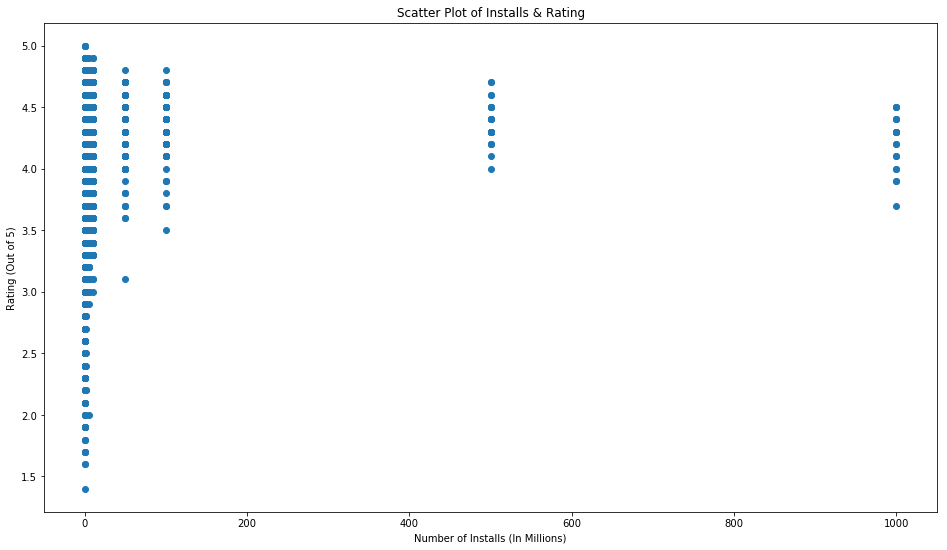

In [470]:
#scatter plot of ratings & installs
pylab.rcParams['figure.figsize'] = (16, 9)
installs_ = df_apps.installs_int.apply(lambda x: x/1000000)
plt.scatter(installs_, df_apps.Rating)
plt.title('Scatter Plot of Installs & Rating')
plt.xlabel('Number of Installs (In Millions)')
plt.ylabel('Rating (Out of 5)')

plt.show()

In [384]:
#reviews sentiments
#load data
df_reviews = pd.read_csv('googleplaystore_user_reviews_origin.csv')
print('original lenght:', len(df_reviews.App.unique()))
df_reviews = df_reviews[['App','Sentiment']].dropna()
print('after dropping na:', len(df_reviews.App.unique()))
df_reviews.head()

original lenght: 1074
after dropping na: 865


,App,Sentiment
0,10 Best Foods for You,Positive
1,10 Best Foods for You,Positive
3,10 Best Foods for You,Positive
4,10 Best Foods for You,Positive
5,10 Best Foods for You,Positive


In [394]:
#join tables

#df_apps_i = df_apps.set_index('App')
#df_reviews_i = df_reviews.set_index('App')

df_apps.keys = df_apps.App
df_reviews.keys = df_reviews.App

df_joined = df_reviews_i.join(df_apps_i, lsuffix='_review', rsuffix='_app')
df_joined = df_joined[['Sentiment', 'Category','Rating','installs_int']]
df_joined.head()

,Sentiment,Category,Rating,installs_int
App,,,,
10 Best Foods for You,Positive,HEALTH_AND_FITNESS,4,500000.0
10 Best Foods for You,Positive,HEALTH_AND_FITNESS,4,500000.0
10 Best Foods for You,Positive,HEALTH_AND_FITNESS,4,500000.0
10 Best Foods for You,Positive,HEALTH_AND_FITNESS,4,500000.0
10 Best Foods for You,Positive,HEALTH_AND_FITNESS,4,500000.0


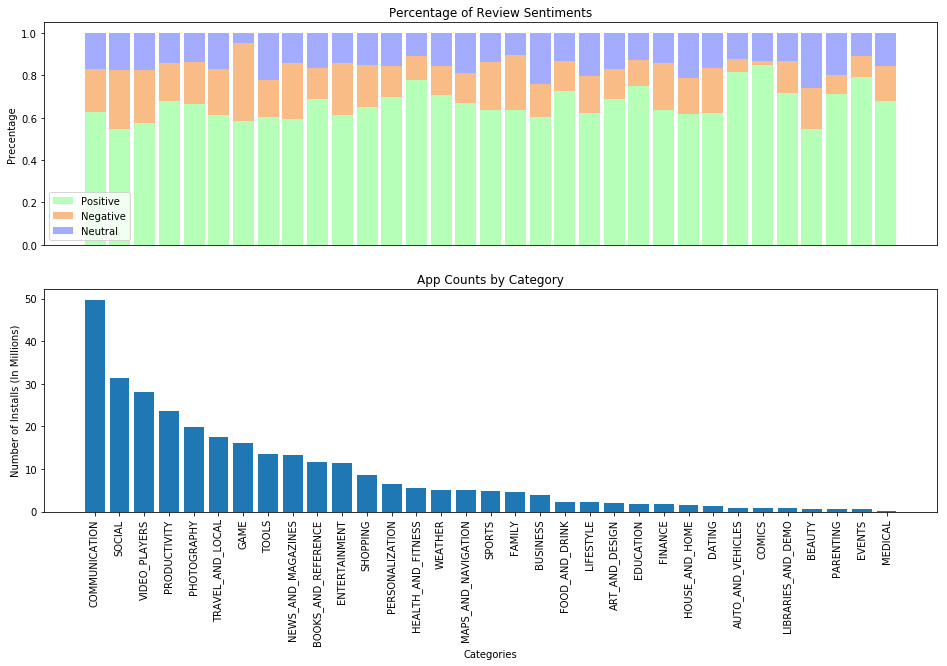

In [437]:
#review sentiment percentage by category


#prep data
#constructu sentiment percentage table
categories = df_joined.Category.value_counts().keys()
sent_pct_lookup = {}

for cate in categories:
    sent_ = df_joined[df_joined.Category == cate]['Sentiment'].value_counts()
    sent_pct = sent_/sent_.sum()
    sent_pct_lookup[cate] = sent_pct
    
#get mean install number rank
means = []
for cate in categories:
    group_ = df_apps[df_apps.Category == cate]['installs_int']
    means.append(group_.mean())
    
#sorting
sort_by_mean = pd.DataFrame({
        'cate_':categories,
        'means_':means
    })
sort_by_mean.sort_values('means_', ascending=False, inplace=True)
sort_by_mean['means_'] = sort_by_mean.means_.apply(lambda x: x/1000000)

#plotting
pylab.rcParams['figure.figsize'] = (16, 9)
fig = plt.figure()

#plot percentage
ax1 = fig.add_subplot(211)
    
r = list(range(len(categories)))
sent_pct_df = pd.DataFrame(sent_pct_lookup)
bar_w = .85

pos_ = np.array([sent_pct_lookup[cate]['Positive'] for cate in sort_by_mean.cate_])
neg_ = np.array([sent_pct_lookup[cate]['Negative'] for cate in sort_by_mean.cate_])
neu_ = np.array([sent_pct_lookup[cate]['Neutral'] for cate in sort_by_mean.cate_])

ax1.bar(r, pos_, color='#b5ffb9', width=bar_w, label='Positive')
ax1.bar(r, neg_, bottom=pos_, color='#f9bc86', width=bar_w, label='Negative')
ax1.bar(r, neu_, bottom=pos_+neg_, color='#a3acff', width=bar_w, label='Neutral')
ax1.axes.get_xaxis().set_visible(False)
ax1.set_title('Percentage of Review Sentiments')
ax1.legend()
ax1.set_ylabel('Precentage')

#plot avg installs
ax2 = fig.add_subplot(212)
xs = list(range(len(sort_by_mean)))
ax2.bar(xs, height=sort_by_mean.means_)
ax2.set_title('Average Installs by Category')
ax2.set_xticks(xs)
ax2.set_xticklabels(sort_by_mean.cate_, rotation=90)
ax2.set_title('App Counts by Category')
ax2.set_xlabel('Categories')
ax2.set_ylabel('Number of Installs (In Millions)')

plt.show()
 

In [232]:
#predicting installs
#imports
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import statsmodels.api as sm
from scipy import stats


In [474]:
#features & encodings    
    
#trying target encoding here
    #creating new feature
    #replacing category with mean installs of that category
    #should exclude test data when calculating the avg lookup table
        #to do later
    
def avg_installs_by_category():
    categories = df_apps.Category.value_counts().keys()
    means = []
    for cate in categories:
        group_ = df_apps[df_apps.Category == cate]['installs_int']
        means.append(group_.mean())

    sort_by_mean = pd.DataFrame({
            'cate_':categories,
            'means_':means
        })
    
    avg_ins_lookup = {}
    for item in sort_by_mean.iterrows():
        cate_ = item[1][0]
        mean_ins_ = item[1][1]
        avg_ins_lookup[cate_] = mean_ins_

    return avg_ins_lookup

avg_ins = avg_installs_by_category()
df_apps['category_target'] = df_apps.Category.apply(lambda x: avg_ins[x])

#spliting xs & y
for_model = df_apps.dropna()
predictors = [
    'Rating',
    'Size',
    'Price',
    'reviews_per_install',
    'updated_delta',
    'category_target'
]
xs = for_model[predictors]
y = for_model.installs_int

#train test split
xtrain, xtest, ytrain, ytest = train_test_split(xs, y, test_size=.2)

,Rating,Size,Price,reviews_per_install,updated_delta,category_target,y
0,4.1,19000.0,0.0,0.015900,236,2.022054e+06,10000
2,4.7,87000.0,0.0,0.017502,30,2.022054e+06,5000000
3,4.5,25000.0,0.0,0.004313,84,2.022054e+06,50000000
4,4.3,28000.0,0.0,0.009670,72,2.022054e+06,100000
5,4.4,56000.0,0.0,0.003340,523,2.022054e+06,50000


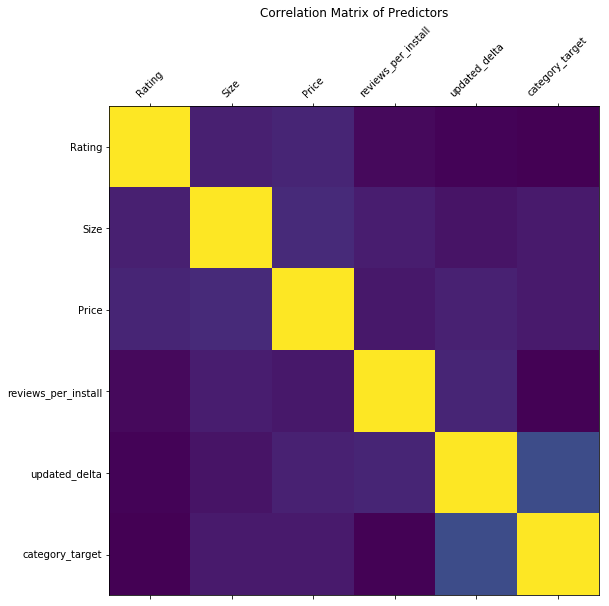

In [475]:
#correlation matrix
corr_mat = xs.copy()
corr_mat['y'] = pd.Series(y)


fig = plt.figure()
ax = fig.add_subplot(111)
ax.matshow(corr_mat.corr())


ticks_ = list(range(len(corr_mat.columns[:-1])))
ax.set_xticks(ticks_)
ax.set_yticks(ticks_)
ax.set_xticklabels(corr_mat.columns[:-1], rotation=45)
ax.set_yticklabels(corr_mat.columns[:-1])
ax.set_title('Correlation Matrix of Predictors', y=1.17)

corr_mat.head()

In [441]:
#revise predictors
predictors = [
    'Rating',
    'Size',
    #'Price',
    #'reviews_per_install',
    'updated_delta',
    'category_target'
]
xs = for_model[predictors]
y = for_model.installs_int

In [442]:
#cv opt
def cv_opt(xtrain, xtest, ytrain, ytest, model_ins, parameters, test_size=.2, n_folds=5):
    gs = GridSearchCV(model_ins, param_grid=parameters, cv=n_folds)
    gs.fit(xtrain, ytrain)
    best_ins = gs.best_estimator_
    train_score = best_ins.score(xtrain, ytrain)
    test_score = best_ins.score(xtest, ytest)
    print(str(model_ins))
    print('train score: {}'.format(train_score))
    print('test score: {}'.format(test_score))
    print('opt param:', gs.best_params_)
    print('')

    return best_ins, gs.best_params_

In [443]:
#lm & knn
lm_reg = linear_model.LinearRegression()
lm_cls = linear_model.LogisticRegression()
knn_cls = KNeighborsClassifier()

result = cv_opt(xtrain, xtest, ytrain, ytest, lm_reg, {})
result = cv_opt(xtrain, xtest, ytrain, ytest, lm_cls, {})
result = cv_opt(xtrain, xtest, ytrain, ytest, knn_cls, {})

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
train score: 0.05112971540616462
test score: 0.0019074743243495673
opt param: {}

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
train score: 0.21294439380127622
test score: 0.20116618075801748
opt param: {}

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
train score: 0.4324521422060164
test score: 0.18950437317784258
opt param: {}



In [280]:
#svm stuff
Cs = [.001, .01, .1, 1]# + list(range(1,100,10))
gammas = [0.001, 0.01, 0.1, 1]
param_svc = {'C': Cs, 'gamma':gammas}
svm_cls = svm.SVC()

#result = cv_opt(xtrain, xtest, ytrain, ytest, svm_cls, param_svc)

#this is overfitting like a champ [palmface]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
train score: 0.9577028258887876
test score: 0.22667638483965014
opt param: {'gamma': 1, 'C': 1}



In [476]:
#linear model with fitting stats
diabetes = datasets.load_diabetes()
dia_x= diabetes.data
dia_y= diabetes.target

xs = for_model[predictors].as_matrix()
y = for_model.installs_int.as_matrix()
xs = xs.astype(np.float)
y = y.astype(np.float)

xs_sm = sm.add_constant(xs)
est = sm.OLS(y, xs_sm)
est2 = est.fit()
print(est2.summary())
predictors

#only Price & reviews per install don't have a relationship with install numbers

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     52.10
Date:                Mon, 10 Dec 2018   Prob (F-statistic):           4.78e-63
Time:                        18:57:28   Log-Likelihood:            -1.3278e+05
No. Observations:                6857   AIC:                         2.656e+05
Df Residuals:                    6850   BIC:                         2.656e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.711e+07   7.37e+06     -2.320      0.0

['Rating',
 'Size',
 'Price',
 'reviews_per_install',
 'updated_delta',
 'category_target']